Get NEXRAD data from AWS, get severe reports from SPC archive, and plot a loop of them! Here we use the August 2020 derecho as an example
------------

#### Pulling radar data follows from: https://nexradaws.readthedocs.io/en/latest/Tutorial.html
#### Radar plotting follows from:  https://github.com/ARM-DOE/pyart/blob/master/examples/plotting/plot_ppi_with_rings.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import pyart
import pandas as pd

import nexradaws
import tempfile
import pytz

templocation = tempfile.mkdtemp()

import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/pyart/io/nexrad_level3.py:72: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from xdrlib import Unpacker
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/botocore/utils.py:15: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


#### Get NEXRAD data

In [2]:
### Define the radar, start time and end time
radar_id = 'KDVN'
start = pd.Timestamp(2020,8,10,16,30).tz_localize(tz='UTC')
end = pd.Timestamp(2020,8,10,21,0).tz_localize(tz='UTC')

### Bounds of map we want to plot
min_lon = -93.25
max_lon = -88.
min_lat = 40.35
max_lat = 43.35

In [3]:
#### and get the data
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))
print(scans[0:4])

## download these files
#results = conn.download(scans[0:2], templocation)
results = conn.download(scans, templocation)

There are 47 scans available between 2020-08-10 16:30:00+00:00 and 2020-08-10 21:00:00+00:00

[<AwsNexradFile object - 2020/08/10/KDVN/KDVN20200810_163057_V06>, <AwsNexradFile object - 2020/08/10/KDVN/KDVN20200810_163606_V06>, <AwsNexradFile object - 2020/08/10/KDVN/KDVN20200810_164148_V06>, <AwsNexradFile object - 2020/08/10/KDVN/KDVN20200810_164730_V06>]
Downloaded KDVN20200810_165937_V06
Downloaded KDVN20200810_163057_V06
Downloaded KDVN20200810_165328_V06
Downloaded KDVN20200810_164730_V06
Downloaded KDVN20200810_163606_V06
Downloaded KDVN20200810_165937_V06_MDM
Downloaded KDVN20200810_170533_V06
Downloaded KDVN20200810_171144_V06
Downloaded KDVN20200810_171754_V06
Downloaded KDVN20200810_172407_V06
Downloaded KDVN20200810_164148_V06
Downloaded KDVN20200810_173032_V06
Downloaded KDVN20200810_173714_V06
Downloaded KDVN20200810_175037_V06
Downloaded KDVN20200810_175718_V06_MDM
Downloaded KDVN20200810_174355_V06
Downloaded KDVN20200810_182407_V06
Downloaded KDVN20200810_175718_V06
Dow

### Now get the severe reports from the SPC site. This assumes you're plotting a year far enough in the past that SPC has official records available. If plotting a more recent time period, then the local storm reports archive at IEM is a good source

In [4]:
### wind reports
wind_rpts = pd.read_csv("https://www.spc.noaa.gov/wcm/data/"+str(start.year)+"_wind.csv")

wind_rpts['datetime'] = pd.to_datetime(wind_rpts.date + ' ' + wind_rpts.time) ## convert to datetime
wind_rpts.set_index("datetime",inplace=True)

### times in the file are given in central standard time (UTC+6). Localize, and convert to UTC
wind_rpts.index = wind_rpts.index.tz_localize("Etc/GMT+6",ambiguous='NaT',nonexistent='shift_forward').tz_convert("UTC")

## subset down to 30 minutes before/after the radar times we're plotting
wind_rpts = wind_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):((end+pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M"))]
wind_rpts


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,mt
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 16:00:00+00:00,693935,2020,8,10,2020-08-10,10:00:00,3,IA,19,0,...,0,0,0,0,0,153,0,0,0,EG
2020-08-10 16:00:00+00:00,693936,2020,8,10,2020-08-10,10:00:00,3,IA,19,0,...,0,0,0,0,0,153,0,0,0,EG
2020-08-10 16:01:00+00:00,693937,2020,8,10,2020-08-10,10:01:00,3,IA,19,0,...,0,0,0,0,0,153,0,0,0,MG
2020-08-10 16:02:00+00:00,693938,2020,8,10,2020-08-10,10:02:00,3,IA,19,0,...,0,0,0,0,0,187,0,0,0,EG
2020-08-10 16:03:00+00:00,693939,2020,8,10,2020-08-10,10:03:00,3,IA,19,0,...,0,0,0,0,0,181,0,0,0,EG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 21:25:00+00:00,694337,2020,8,10,2020-08-10,15:25:00,3,MA,25,0,...,0,0,0,0,0,3,0,0,0,EG
2020-08-10 21:25:00+00:00,694338,2020,8,10,2020-08-10,15:25:00,3,AL,1,0,...,0,0,0,0,0,45,0,0,0,EG
2020-08-10 21:25:00+00:00,694339,2020,8,10,2020-08-10,15:25:00,3,IL,17,0,...,0,0,0,0,0,19,0,0,0,EG


In [5]:
### repeat for tornado reports
tor_rpts = pd.read_csv("https://www.spc.noaa.gov/wcm/data/"+str(start.year)+"_torn.csv")

tor_rpts['datetime'] = pd.to_datetime(tor_rpts.date + ' ' + tor_rpts.time) ## convert to datetime
tor_rpts.set_index("datetime",inplace=True)

### times in the file are given in central standard time (UTC+6). Localize, and convert to UTC
tor_rpts.index = tor_rpts.index.tz_localize("Etc/GMT+6",ambiguous='NaT',nonexistent='shift_forward').tz_convert("UTC")

## subset down to 30 minutes before/after the radar times we're plotting
tor_rpts = tor_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):((end+pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M"))]
tor_rpts


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_28019/3731714186.py:11: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  tor_rpts = tor_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):((end+pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M"))]


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 16:30:00+00:00,619402,2020,8,10,2020-08-10,10:30:00,3,IA,19,0,...,1.03,50,1,1,1,127,0,0,0,0
2020-08-10 16:36:00+00:00,619403,2020,8,10,2020-08-10,10:36:00,3,IA,19,0,...,0.42,50,1,1,1,127,0,0,0,0
2020-08-10 16:39:00+00:00,619404,2020,8,10,2020-08-10,10:39:00,3,IA,19,0,...,2.88,100,1,1,1,127,0,0,0,0
2020-08-10 17:01:00+00:00,619405,2020,8,10,2020-08-10,11:01:00,3,IA,19,0,...,1.48,40,1,1,1,171,0,0,0,0
2020-08-10 17:31:00+00:00,619406,2020,8,10,2020-08-10,11:31:00,3,IA,19,0,...,0.92,40,1,1,1,113,0,0,0,0
2020-08-10 17:32:00+00:00,619407,2020,8,10,2020-08-10,11:32:00,3,WI,55,0,...,0.55,50,1,1,1,43,0,0,0,0
2020-08-10 19:12:00+00:00,619408,2020,8,10,2020-08-10,13:12:00,3,IL,17,0,...,4.59,50,1,1,1,177,0,0,0,0
2020-08-10 19:37:00+00:00,619409,2020,8,10,2020-08-10,13:37:00,3,IL,17,0,...,1.58,50,1,1,1,201,0,0,0,0
2020-08-10 19:47:00+00:00,619410,2020,8,10,2020-08-10,13:47:00,3,IL,17,0,...,9.18,300,1,1,1,201,7,0,0,0


In [6]:
### repeat for hail
hail_rpts = pd.read_csv("https://www.spc.noaa.gov/wcm/data/"+str(start.year)+"_hail.csv")

hail_rpts['datetime'] = pd.to_datetime(hail_rpts.date + ' ' + hail_rpts.time) ## convert to datetime
hail_rpts.set_index("datetime",inplace=True)

### times in the file are given in central standard time (UTC+6). Localize, and convert to UTC
hail_rpts.index = hail_rpts.index.tz_localize("Etc/GMT+6",ambiguous='NaT',nonexistent='shift_forward').tz_convert("UTC")

## subset down to 30 minutes before/after the radar times we're plotting
hail_rpts = hail_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):((end+pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M"))]
hail_rpts

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,elon,len,wid,ns,sn,sg,f1,f2,f3,f4
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 18:25:00+00:00,656603,2020,8,10,2020-08-10,12:25:00,3,IA,19,0,...,-90.9900,0,0,0,0,0,61,0,0,0
2020-08-10 18:35:00+00:00,656604,2020,8,10,2020-08-10,12:35:00,3,IL,17,0,...,-89.6200,0,0,0,0,0,177,0,0,0
2020-08-10 19:45:00+00:00,656605,2020,8,10,2020-08-10,13:45:00,3,MI,26,0,...,-87.6100,0,0,0,0,0,109,0,0,0
2020-08-10 19:53:00+00:00,656606,2020,8,10,2020-08-10,13:53:00,3,IL,17,0,...,-88.9800,0,0,0,0,0,201,0,0,0
2020-08-10 20:00:00+00:00,656607,2020,8,10,2020-08-10,14:00:00,3,IL,17,0,...,-88.8600,0,0,0,0,0,7,0,0,0
2020-08-10 20:27:00+00:00,656608,2020,8,10,2020-08-10,14:27:00,3,IL,17,0,...,-88.4200,0,0,0,0,0,63,0,0,0
2020-08-10 20:29:00+00:00,656609,2020,8,10,2020-08-10,14:29:00,3,IL,17,0,...,-88.4328,0,0,0,0,0,63,0,0,0
2020-08-10 20:30:00+00:00,656610,2020,8,10,2020-08-10,14:30:00,3,IL,17,0,...,-88.3500,0,0,0,0,0,93,0,0,0
2020-08-10 20:43:00+00:00,656611,2020,8,10,2020-08-10,14:43:00,3,IL,17,0,...,-88.0527,0,0,0,0,0,43,0,0,0


### Now, plot the maps (reflectivity with severe reports)

1
working on KDVN20200810_163057_V06


/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


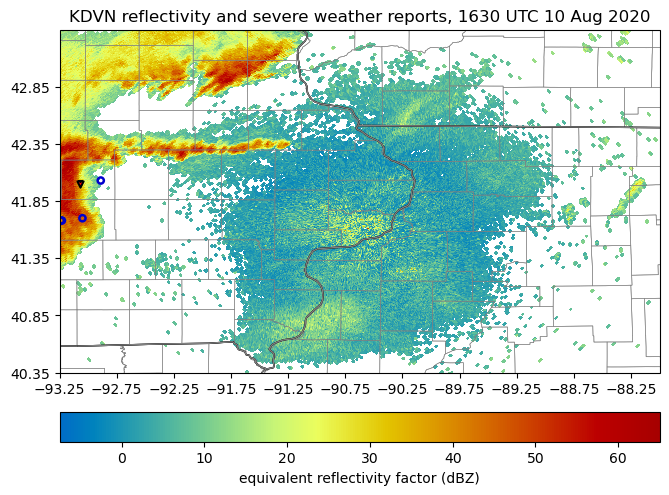

2
working on KDVN20200810_163606_V06


/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)

KeyboardInterrupt



In [9]:
### loop over the radar images that have been downloaded

for i,scan in enumerate(results.iter_success(),start=1):
#for i in range(0,1):
    ## skip the files ending in "MDM"
    if scan.filename[-3:] != "MDM":
        
        print(str(i))
        print("working on "+scan.filename)
        
        this_time = pd.to_datetime(scan.filename[4:17], format="%Y%m%d_%H%M").tz_localize("UTC")
    
        radar = scan.open_pyart()
        #display = pyart.graph.RadarDisplay(radar)

        fig = plt.figure(figsize=[15, 7])

        map_panel_axes = [0.05, 0.05, .4, .80]
        x_cut_panel_axes = [0.55, 0.10, .4, .25]
        y_cut_panel_axes = [0.55, 0.50, .4, .25]

        projection = ccrs.PlateCarree()

        ## apply gatefilter (see here: https://arm-doe.github.io/pyart/notebooks/masking_data_with_gatefilters.html)
        #gatefilter = pyart.correct.moment_based_gate_filter(radar)
        gatefilter = pyart.filters.GateFilter(radar)

        # Lets remove reflectivity values below a threshold.
        gatefilter.exclude_below('reflectivity', -2.5)

        display = pyart.graph.RadarMapDisplay(radar)
       
        ### set up plot
        ax1 = fig.add_axes(map_panel_axes, projection=projection)
        
        # Add some various map elements to the plot to make it recognizable.
        ax1.add_feature(USCOUNTIES.with_scale('500k'), edgecolor="gray", linewidth=0.4)
        #ax1.coastlines('50m', edgecolor='black', linewidth=0.75)
        ax1.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.0)
    
        cf = display.plot_ppi_map('reflectivity', 0, vmin=-7.5, vmax=65,
                                  ax=ax1,
                          min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                          title=radar_id+" reflectivity and severe weather reports, "+this_time.strftime("%H%M UTC %d %b %Y"),
                          projection=projection, resolution='10m',
                             gatefilter=gatefilter,
                          cmap='pyart_HomeyerRainbow', 
                          colorbar_flag=False,
                          lat_lines=[0,0], lon_lines=[0,0]) ## turns off lat/lon grid lines
        #display.plot_crosshairs(lon=lon, lat=lat)
        
        ## plot horizontal colorbar 
        display.plot_colorbar(cf,orient='horizontal', pad=0.07)
        
        # Plot range rings if desired
        #display.plot_range_ring(25., color='gray', linestyle='dashed')
        #display.plot_range_ring(50., color='gray', linestyle='dashed')
        #display.plot_range_ring(100., color='gray', linestyle='dashed')

        ax1.set_xticks(np.arange(min_lon, max_lon, .5), crs=ccrs.PlateCarree())
        ax1.set_yticks(np.arange(min_lat, max_lat, .5), crs=ccrs.PlateCarree())     
       
        ## add marker points for severe reports
        wind_rpts_now = wind_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):this_time.strftime("%Y-%m-%d %H:%M")]
        ax1.scatter(wind_rpts_now.slon.values.tolist(), wind_rpts_now.slat.values.tolist(), s=20, facecolors='none', edgecolors='mediumblue', linewidths=1.8)
        tor_rpts_now = tor_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):this_time.strftime("%Y-%m-%d %H:%M")]
        ax1.scatter(tor_rpts_now.slon.values.tolist(), tor_rpts_now.slat.values.tolist(), s=20, facecolors='red', edgecolors='black', marker="v",linewidths=1.5)
        hail_rpts_now = hail_rpts[((start-pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")):this_time.strftime("%Y-%m-%d %H:%M")]
        ax1.scatter(hail_rpts_now.slon.values.tolist(), hail_rpts_now.slat.values.tolist(), s=20, facecolors='none', edgecolors='green', linewidths=1.8)

        
        plt.savefig(scan.radar_id+"_"+scan.filename[4:17]+"_dz_rpts.png",bbox_inches='tight',dpi=300,
                   facecolor='white', transparent=False)
        plt.show()
        plt.close('all')
